# Numerical differentiation using interpolation and extrapolation 

## Getting derivatives of data that are the same length as the input data
#### very useful in getting dy/dt of motion correction parameters that is same length as your input data

### Tutorial by Daan van Es (daan.van.es@gmail.com)

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import seaborn as sn

In [3]:
%matplotlib inline 

Lets create some linearly increasing data + random noise 

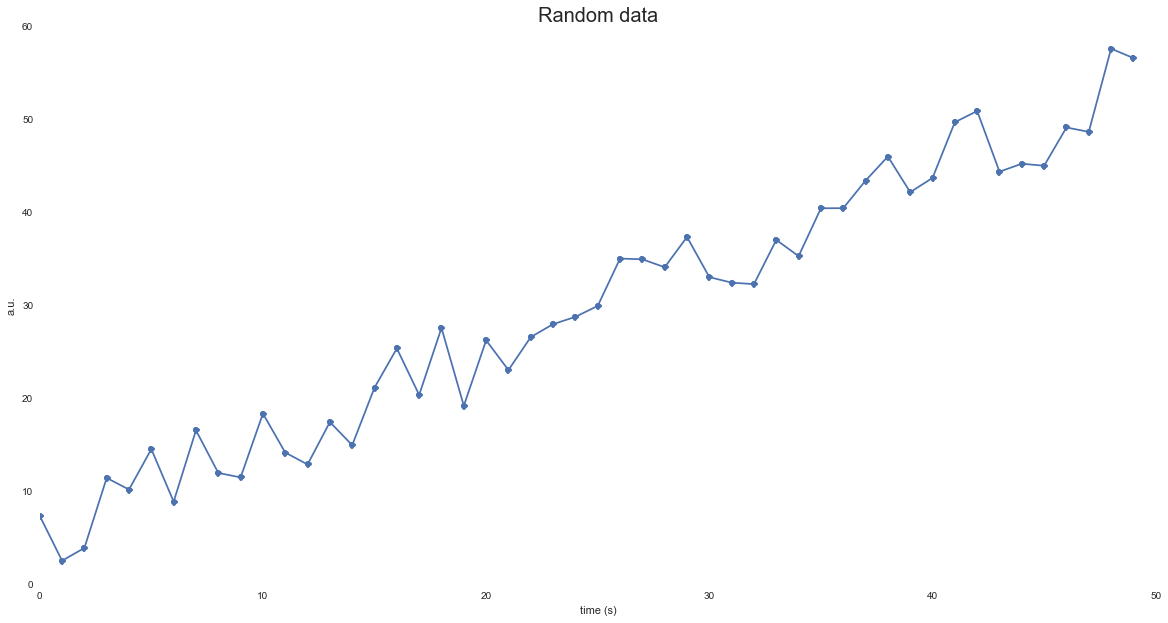

In [4]:
data = np.arange(50) + np.random.rand(50)*10
pl.figure(figsize=(20,10))
pl.plot(data,'-o')
pl.title('Random data',fontsize=20)
pl.xlabel('time (s)')
pl.ylabel('a.u.')

To get the derivative of these data, we can simply take the np.diff:

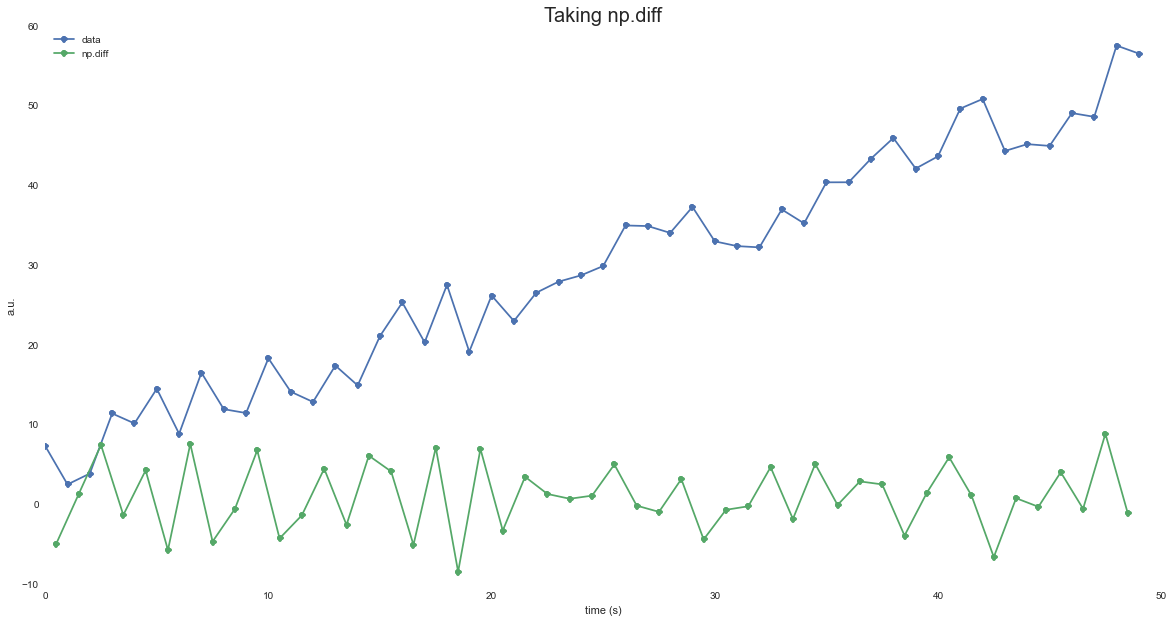

In [5]:
diff_data = np.diff(data)
pl.figure(figsize=(20,10))
pl.plot(data,'-o')
pl.plot(np.arange(0.5,49.5),diff_data,'-o')
pl.legend(['data', 'np.diff'],loc='best')
pl.title('Taking np.diff',fontsize=20)
pl.xlabel('time (s)')
pl.ylabel('a.u.')

A problem with np.diff however, is that because it is taking the difference between all the values, it creates a value 'between' every data point. If you inspect the graph above closely, you can hopefully spot this. We can solve this problem by combining interpolation (to get the values at exact values of x, instead of in-between), and extrapolation (to get at the first and last values of x).

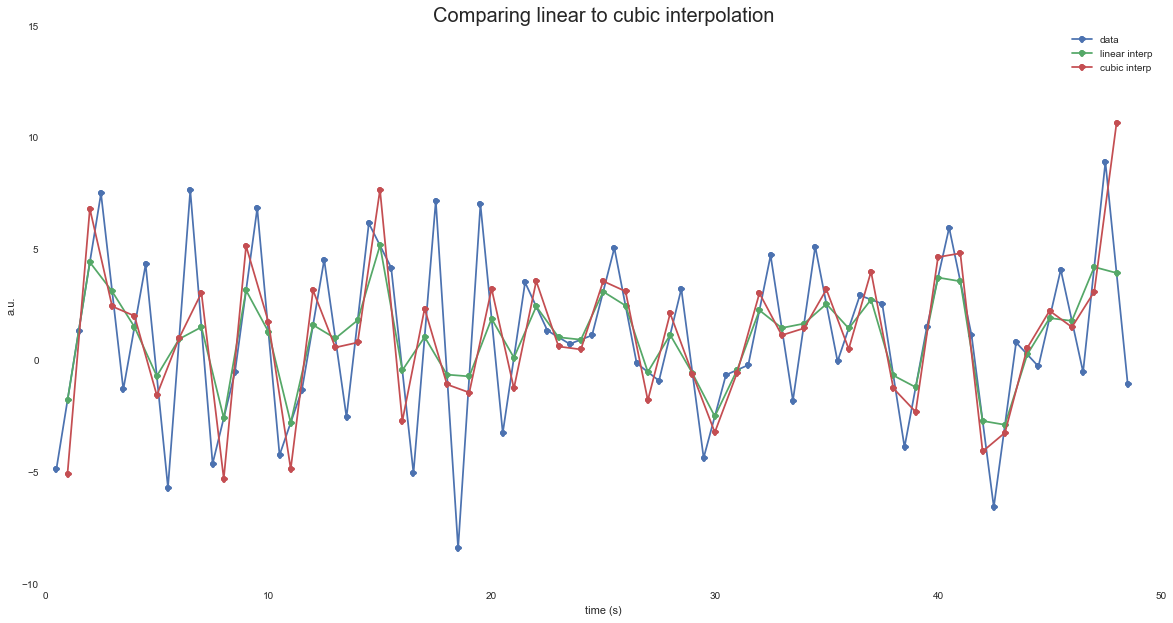

In [6]:
# first define the x's of the data:
x = np.arange(len(data))
# and of the diff
diff_x = np.arange(0.5,len(data)-1)

# now we can interpolate the derivative, either linearly or cubicly:
interp_diff_lin = sp.interpolate.interp1d(diff_x,diff_data,kind='linear')
interp_diff_cub = sp.interpolate.interp1d(diff_x,diff_data,kind='cubic')
# This interpolated function can now be evaluated at any x within it's original range.
# Let's try different x values (as this is what interpolation is usually used for)
interp_x = np.arange(x[1],x[-1])
interp_diff_data_lin = interp_diff_lin(interp_x)
interp_diff_data_cub = interp_diff_cub(interp_x)

# lets compare linear and cubic's performance:
pl.figure(figsize=(20,10))
pl.plot(diff_x,diff_data,'-o')
pl.plot(interp_x,interp_diff_data_lin,'-o')
pl.plot(interp_x,interp_diff_data_cub,'-o')
# pl.xlim(5,25)
pl.legend(['data', 'linear interp','cubic interp'],loc='best')
pl.title('Comparing linear to cubic interpolation',fontsize=20)
pl.xlabel('time (s)')
pl.ylabel('a.u.')

By inspecting this plot, it becomes evident that linear interpolation acts kind of like a low pass filter,  taking values that lie on the linear interpolation between data points (which is exactly what the blue straight lines connecting the data points represent really). The cubic method fits a third order spline through the original data points, and evaluating this spline at the x-points requested. You could choose one over the other for your own reasons depending on what you find important, but I prefer the cubic method as it better reflects the spectral profile of the original data. 

This interpolation method solves the problem that np.diff creates values at 'in-between' x values. However, an important limitation of interpolation is that it cannot be extended beyond the original x-range. As the x-range of the np.diff of the data only covers from 0.5 till len(data)-0.5, we need another trick to get to these ultimate values: extrapolation. Linear extrapolation simply takes the trend existing at the first two and last two data points and continues this trend onwards outside of the original x-range. I found a nice function online that can transform our former interpolation function to include linear extrapolation

In [7]:
def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(map(pointwise, np.array(xs)))

    return ufunclike

# now we can run this function on our interpolation
exterp_diff = extrap1d(interp_diff_cub)

Now, we have a function that can be evaluated at any value, including the 0 and last values of x. Let's plot and compare.

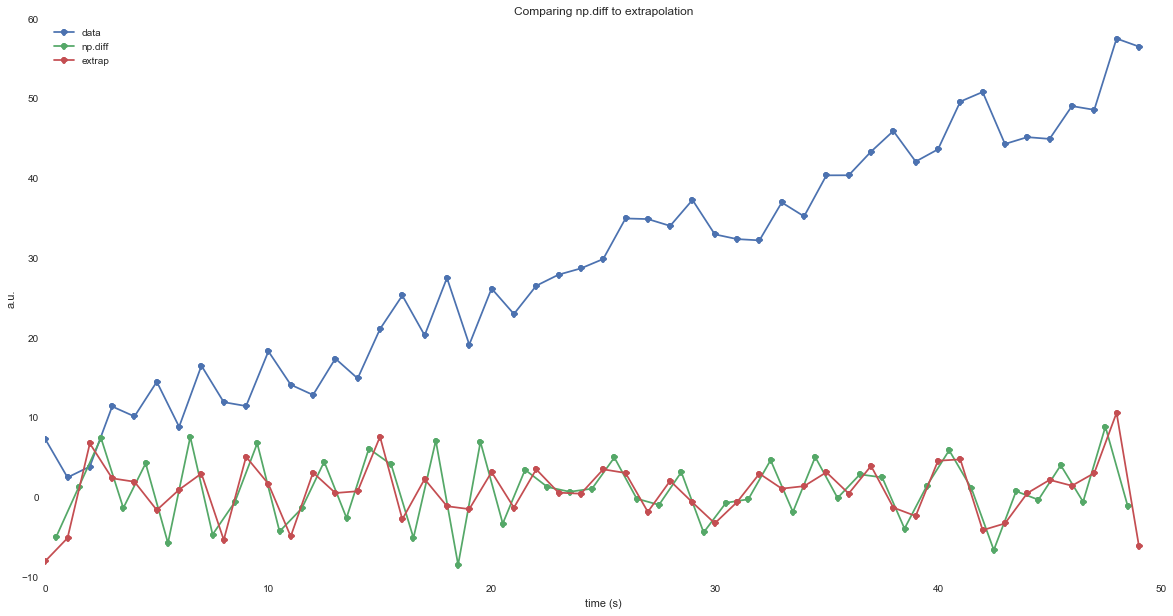

In [8]:
exterp_data = exterp_diff(x)
pl.figure(figsize=(20,10))
pl.plot(x,data,'-o')
pl.plot(diff_x,diff_data,'-o')
pl.plot(x,exterp_data,'-o')
pl.legend(['data', 'np.diff','extrap'],loc='best')
pl.title('Comparing np.diff to extrapolation')
pl.xlabel('time (s)')
pl.ylabel('a.u.')

Let's take a closer look at the start and end of the data

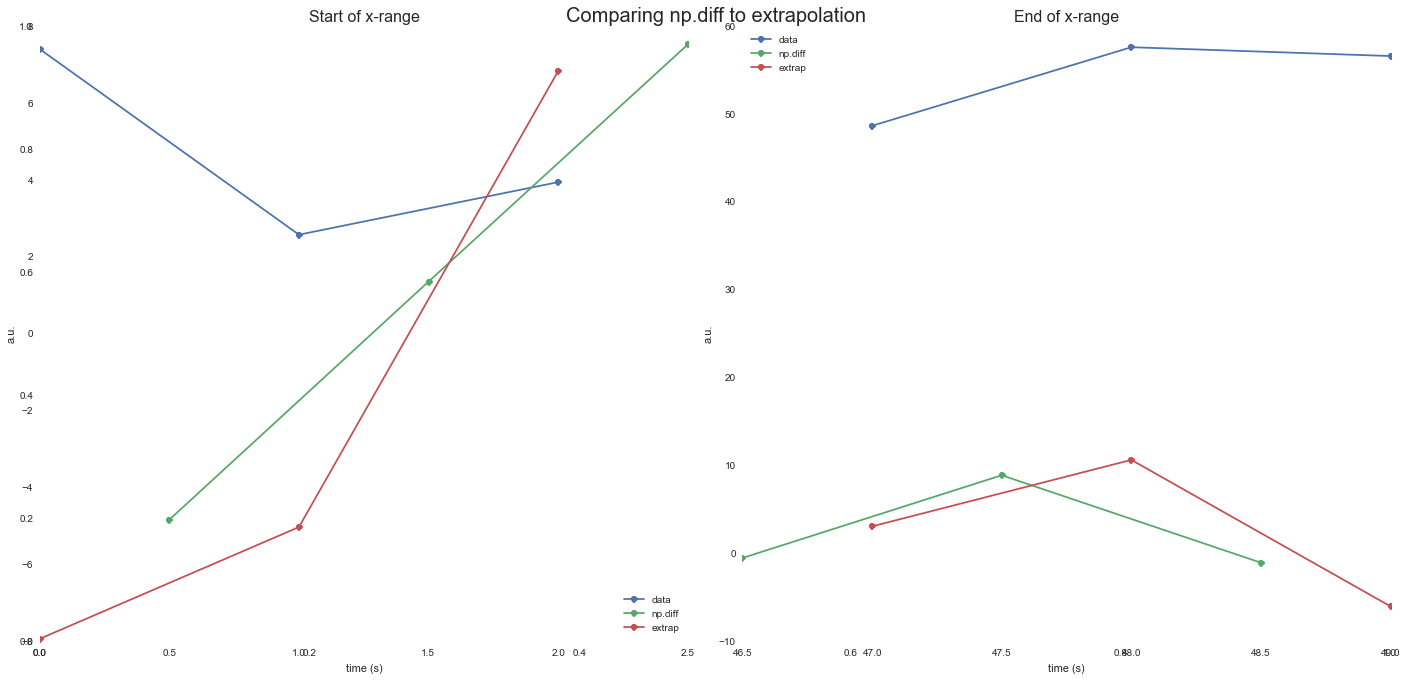

In [9]:
f = pl.figure(figsize=(20,10))
pl.title('Comparing np.diff to extrapolation',fontsize=20)
s = f.add_subplot(121)
pl.title('Start of x-range',fontsize=16)
pl.plot(x[:3],data[:3],'-o')
pl.plot(diff_x[:3],diff_data[:3],'-o')
pl.plot(x[:3],exterp_data[:3],'-o')
pl.legend([ 'data','np.diff','extrap'],loc='best')
pl.xlabel('time (s)')
pl.ylabel('a.u.')
s = f.add_subplot(122)
pl.title('End of x-range',fontsize=16)
pl.plot(x[-3:],data[-3:],'-o')
pl.plot(diff_x[-3:],diff_data[-3:],'-o')
pl.plot(x[-3:],exterp_data[-3:],'-o')
pl.legend(['data','np.diff','extrap'],loc='best')
pl.xlabel('time (s)')
pl.ylabel('a.u.')
pl.tight_layout()

Here's a function that does all this stuff:

In [10]:
def numerical_derivative(data):
    
    diff_data = np.diff(data)
    diff_x = np.arange(0.5,len(data)-1)
    
    interp_diff = sp.interpolate.interp1d(diff_x,diff_data,kind='cubic')

    def extrap1d(interpolator):
        xs = interpolator.x
        ys = interpolator.y

        def pointwise(x):
            if x < xs[0]:
                return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
            elif x > xs[-1]:
                return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
            else:
                return interpolator(x)

        def ufunclike(xs):
            return np.array(map(pointwise, np.array(xs)))

        return ufunclike
    
    return extrap1d(interp_diff)(np.arange(len(data)))

Let's see it in action

length data: 50, length derivative: 50


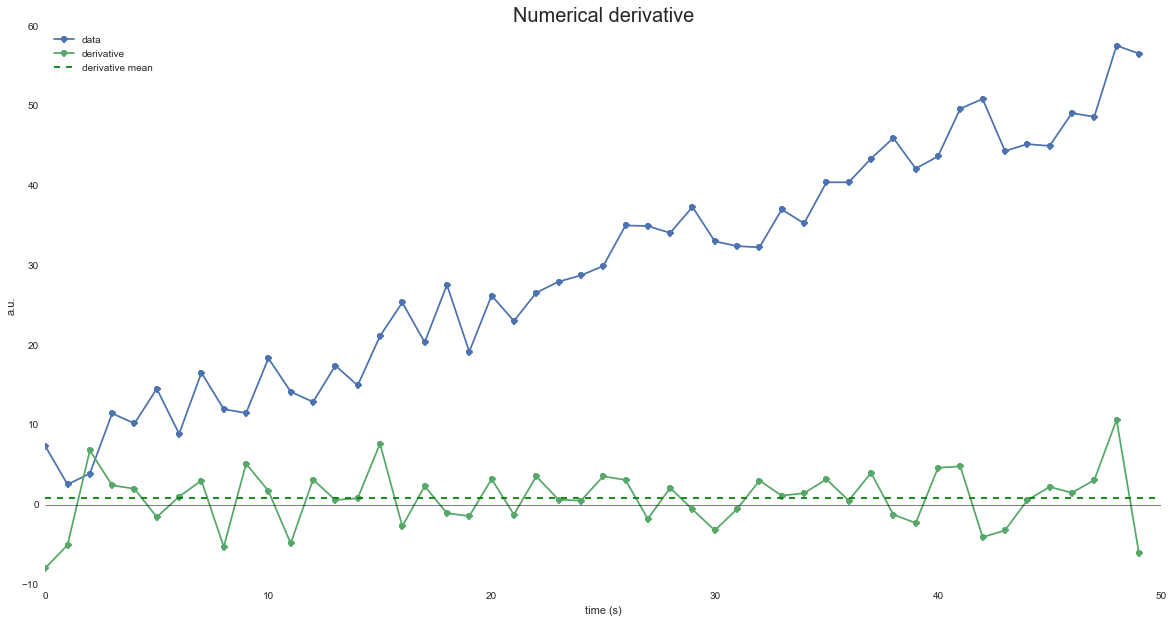

In [19]:
derivative = numerical_derivative(data)
pl.figure(figsize=(20,10))
pl.plot(data,'-o')
pl.plot(derivative,'-o')
pl.axhline(np.mean(derivative),linestyle='--',color='g')
pl.axhline(0,linestyle='-',color='k',linewidth=0.5)
pl.legend(['data', 'derivative','derivative mean'],loc='best')
pl.title('Numerical derivative',fontsize=20)
pl.xlabel('time (s)')
pl.ylabel('a.u.')

print 'length data: %d, length derivative: %d'%(len(data),len(derivative))

You can see the derivative now covers the full data range. Also, the mean of the derivative lies at 1, which is exactly the slope of the data.